# Colab E-ii: TensorFlow with Built-in Layers - 3-Layer Deep Neural Network

## Overview
- **TensorFlow `tf.keras.layers`** for layer definitions
- Uses `tf.keras.layers.Dense` with custom training loop via `tf.GradientTape`
- NOT using `model.fit()` - still manual training loop
- Same 3-variable non-linear regression problem

### Target Non-Linear Equation
$$y = \sin(x_1) \cdot x_2^2 + \cos(x_3) \cdot x_1 + x_2 \cdot x_3^2$$

### Network Architecture
- Input Layer: 3 neurons
- Hidden Layer 1: 64 neurons (ReLU) - `Dense(64, activation='relu')`
- Hidden Layer 2: 32 neurons (ReLU) - `Dense(32, activation='relu')`
- Hidden Layer 3: 16 neurons (ReLU) - `Dense(16, activation='relu')`
- Output Layer: 1 neuron (Linear) - `Dense(1)`

In [1]:
# ============================================================
# Section 1: Imports
# ============================================================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow: {tf.__version__}")
tf.random.set_seed(42)
np.random.seed(42)

TensorFlow: 2.19.0


In [2]:
# ============================================================
# Section 2: Generate Synthetic Data
# ============================================================
N_SAMPLES = 1000

x1 = np.random.uniform(-2, 2, (N_SAMPLES, 1)).astype(np.float32)
x2 = np.random.uniform(-2, 2, (N_SAMPLES, 1)).astype(np.float32)
x3 = np.random.uniform(-2, 2, (N_SAMPLES, 1)).astype(np.float32)

y = (np.sin(x1) * x2**2 + np.cos(x3) * x1 + x2 * x3**2).astype(np.float32)
X = np.hstack([x1, x2, x3])

X_mean, X_std = X.mean(axis=0), X.std(axis=0)
y_mean, y_std = y.mean(), y.std()
X_norm = ((X - X_mean) / X_std).astype(np.float32)
y_norm = ((y - y_mean) / y_std).astype(np.float32)

split = int(0.8 * N_SAMPLES)
X_train, X_test = X_norm[:split], X_norm[split:]
y_train, y_test = y_norm[:split], y_norm[split:]

BATCH_SIZE = 64
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (800, 3), Test: (200, 3)


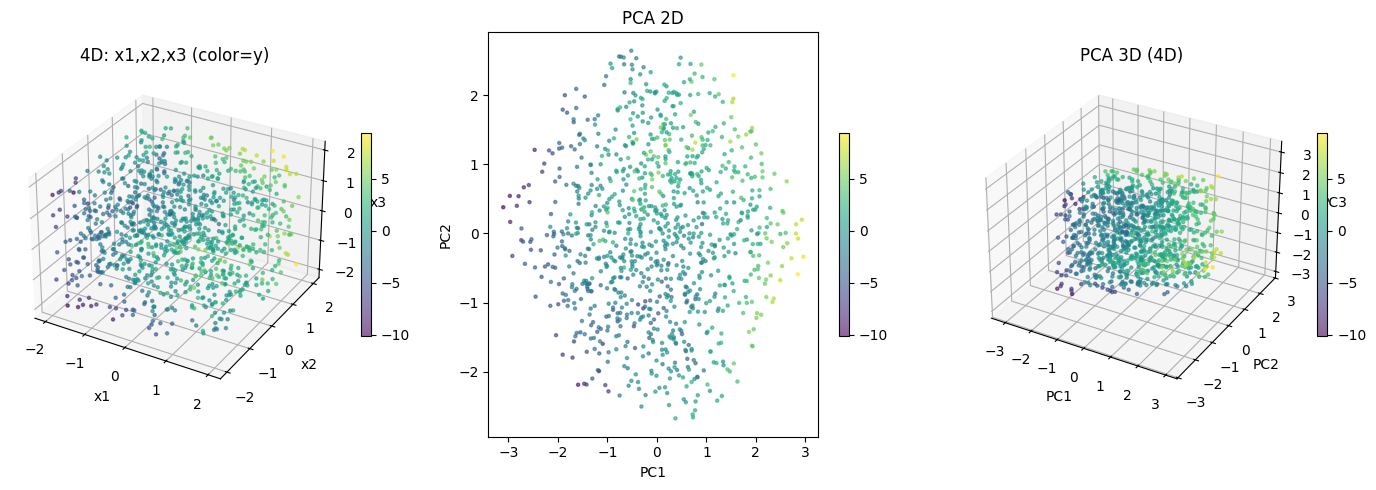

In [3]:
# ============================================================
# Section 3: 4D Data Visualization
# ============================================================
fig = plt.figure(figsize=(14, 5))

ax1 = fig.add_subplot(131, projection='3d')
sc1 = ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=y.flatten(), cmap='viridis', s=5, alpha=0.6)
ax1.set_xlabel('x1'); ax1.set_ylabel('x2'); ax1.set_zlabel('x3')
ax1.set_title('4D: x1,x2,x3 (color=y)')
plt.colorbar(sc1, ax=ax1, shrink=0.5)

pca2 = PCA(n_components=2); Xp2 = pca2.fit_transform(X)
ax2 = fig.add_subplot(132)
sc2 = ax2.scatter(Xp2[:, 0], Xp2[:, 1], c=y.flatten(), cmap='viridis', s=5, alpha=0.6)
ax2.set_xlabel('PC1'); ax2.set_ylabel('PC2'); ax2.set_title('PCA 2D')
plt.colorbar(sc2, ax=ax2, shrink=0.5)

pca3 = PCA(n_components=3); Xp3 = pca3.fit_transform(X)
ax3 = fig.add_subplot(133, projection='3d')
sc3 = ax3.scatter(Xp3[:, 0], Xp3[:, 1], Xp3[:, 2], c=y.flatten(), cmap='viridis', s=5, alpha=0.6)
ax3.set_xlabel('PC1'); ax3.set_ylabel('PC2'); ax3.set_zlabel('PC3')
ax3.set_title('PCA 3D (4D)')
plt.colorbar(sc3, ax=ax3, shrink=0.5)

plt.tight_layout()
plt.show()

In [4]:
# ============================================================
# Section 4: Build Model Using tf.keras.layers.Dense
# ============================================================
# Using built-in Dense layers but with CUSTOM training loop

# Define layers individually (not using Sequential yet - just layers)
dense1 = layers.Dense(64, activation='relu',
                      kernel_initializer='he_normal',
                      name='hidden_1')
dense2 = layers.Dense(32, activation='relu',
                      kernel_initializer='he_normal',
                      name='hidden_2')
dense3 = layers.Dense(16, activation='relu',
                      kernel_initializer='he_normal',
                      name='hidden_3')
output_layer = layers.Dense(1, name='output')

# Build layers by passing dummy input
dummy = tf.zeros((1, 3))
_ = output_layer(dense3(dense2(dense1(dummy))))

# Collect all trainable variables
all_layers = [dense1, dense2, dense3, output_layer]
all_variables = []
for layer in all_layers:
    all_variables.extend(layer.trainable_variables)

print("Built-in Layers (Dense):")
for layer in all_layers:
    w = layer.trainable_variables
    n = sum(v.numpy().size for v in w)
    print(f"  {layer.name}: {[v.shape.as_list() for v in w]} ({n} params)")

total = sum(v.numpy().size for v in all_variables)
print(f"Total parameters: {total}")

Built-in Layers (Dense):
  hidden_1: [[3, 64], [64]] (256 params)
  hidden_2: [[64, 32], [32]] (2080 params)
  hidden_3: [[32, 16], [16]] (528 params)
  output: [[16, 1], [1]] (17 params)
Total parameters: 2881


In [5]:
# ============================================================
# Section 5: Forward Pass Function
# ============================================================

@tf.function
def forward(X):
    """Forward pass through built-in Dense layers."""
    h1 = dense1(X)
    h2 = dense2(h1)
    h3 = dense3(h2)
    out = output_layer(h3)
    return out

# Test
test_out = forward(tf.constant(X_train[:5]))
print(f"Forward test: {test_out.numpy().flatten()}")

Forward test: [-0.4085526  -0.37691554 -0.5875331  -0.3350135  -0.74868894]


In [6]:
# ============================================================
# Section 6: Custom Training Loop with GradientTape
# ============================================================

LEARNING_RATE = 0.001
EPOCHS = 500
optimizer = tf.optimizers.Adam(LEARNING_RATE)
loss_fn = tf.keras.losses.MeanSquaredError()

train_losses = []
test_losses = []

@tf.function
def train_step(X_batch, y_batch):
    with tf.GradientTape() as tape:
        y_pred = forward(X_batch)
        loss = loss_fn(y_batch, y_pred)
    grads = tape.gradient(loss, all_variables)
    optimizer.apply_gradients(zip(grads, all_variables))
    return loss

print(f"Custom training loop with Dense layers + GradientTape")
print(f"LR: {LEARNING_RATE}, Epochs: {EPOCHS}")
print("=" * 60)

for epoch in range(EPOCHS):
    ep_loss = 0.0
    nb = 0
    for xb, yb in train_ds:
        loss = train_step(xb, yb)
        ep_loss += loss.numpy()
        nb += 1

    avg_train = ep_loss / nb
    train_losses.append(avg_train)

    y_tp = forward(tf.constant(X_test))
    t_loss = loss_fn(y_test, y_tp).numpy()
    test_losses.append(t_loss)

    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1:4d}/{EPOCHS}] | Train: {avg_train:.6f} | Test: {t_loss:.6f}")

print("=" * 60)
print(f"Final Train: {train_losses[-1]:.6f}, Test: {test_losses[-1]:.6f}")

Custom training loop with Dense layers + GradientTape
LR: 0.001, Epochs: 500
Epoch [   1/500] | Train: 0.825032 | Test: 0.385762
Epoch [  50/500] | Train: 0.025688 | Test: 0.027286
Epoch [ 100/500] | Train: 0.007752 | Test: 0.012225
Epoch [ 150/500] | Train: 0.003283 | Test: 0.006781
Epoch [ 200/500] | Train: 0.002904 | Test: 0.005681
Epoch [ 250/500] | Train: 0.001875 | Test: 0.005836
Epoch [ 300/500] | Train: 0.001995 | Test: 0.005005
Epoch [ 350/500] | Train: 0.001150 | Test: 0.004630
Epoch [ 400/500] | Train: 0.001484 | Test: 0.005359
Epoch [ 450/500] | Train: 0.000911 | Test: 0.004623
Epoch [ 500/500] | Train: 0.001110 | Test: 0.003522
Final Train: 0.001110, Test: 0.003522


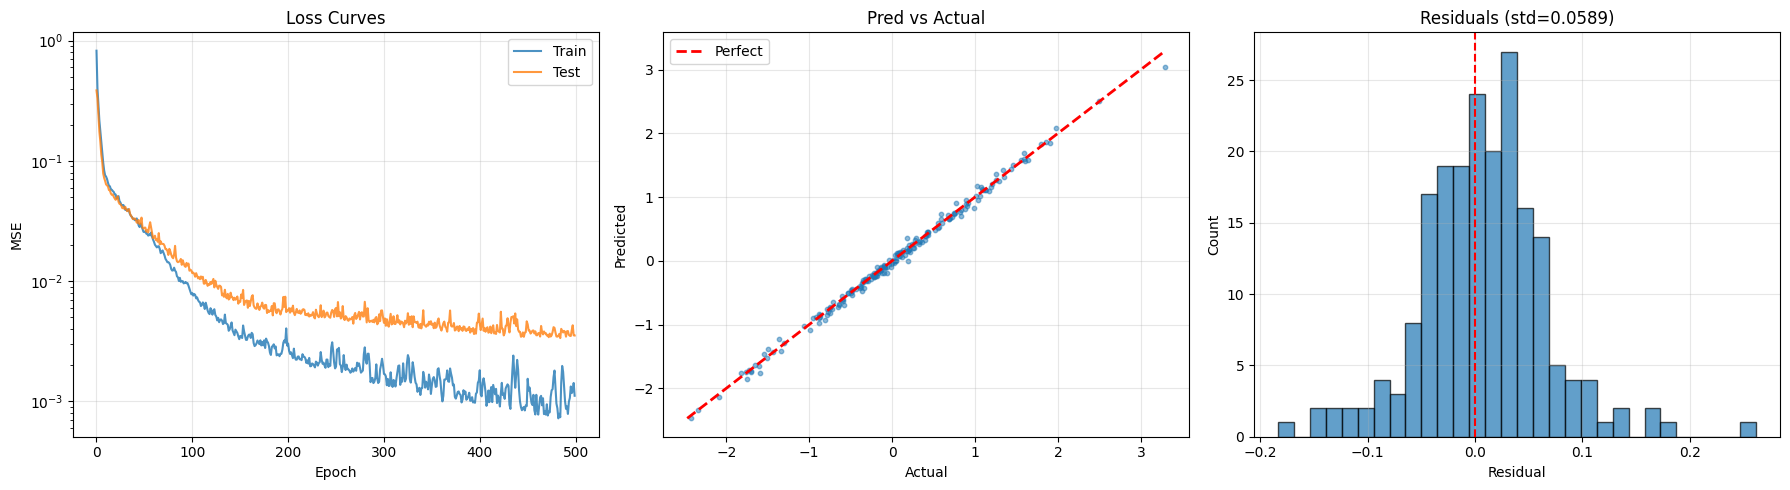

R²: 0.995712, MAE: 0.044087


In [7]:
# ============================================================
# Section 7: Results Visualization
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(train_losses, label='Train', alpha=0.8)
axes[0].plot(test_losses, label='Test', alpha=0.8)
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('MSE')
axes[0].set_title('Loss Curves'); axes[0].legend()
axes[0].set_yscale('log'); axes[0].grid(True, alpha=0.3)

y_final = forward(tf.constant(X_test)).numpy()

axes[1].scatter(y_test, y_final, alpha=0.5, s=10)
mn, mx = min(y_test.min(), y_final.min()), max(y_test.max(), y_final.max())
axes[1].plot([mn, mx], [mn, mx], 'r--', lw=2, label='Perfect')
axes[1].set_xlabel('Actual'); axes[1].set_ylabel('Predicted')
axes[1].set_title('Pred vs Actual'); axes[1].legend()
axes[1].grid(True, alpha=0.3)

res = (y_test - y_final).flatten()
axes[2].hist(res, bins=30, edgecolor='black', alpha=0.7)
axes[2].axvline(0, color='r', linestyle='--')
axes[2].set_xlabel('Residual'); axes[2].set_ylabel('Count')
axes[2].set_title(f'Residuals (std={res.std():.4f})')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

r2 = 1 - np.sum(res**2) / np.sum((y_test.flatten() - y_test.mean())**2)
print(f"R²: {r2:.6f}, MAE: {np.mean(np.abs(res)):.6f}")

In [8]:
# ============================================================
# Section 8: Sample Predictions
# ============================================================
y_to = y_test * y_std + y_mean
y_po = y_final * y_std + y_mean
X_to = X_test * X_std + X_mean

print("Sample Predictions:")
print("=" * 70)
print(f"{'Idx':>5} | {'x1':>7} | {'x2':>7} | {'x3':>7} | {'Actual':>9} | {'Pred':>9} | {'Err':>7}")
print("-" * 70)
for i in range(15):
    a, p = y_to[i,0], y_po[i,0]
    print(f"{i:5d} | {X_to[i,0]:7.3f} | {X_to[i,1]:7.3f} | {X_to[i,2]:7.3f} | {a:9.4f} | {p:9.4f} | {abs(a-p):7.4f}")

print(f"\nRMSE: {np.sqrt(np.mean((y_to-y_po)**2)):.4f}, R²: {r2:.6f}")

print("\n=== Colab E-ii Complete ===")
print("Key: TF built-in Dense layers + custom training loop")
print("- tf.keras.layers.Dense for layer definitions")
print("- He (Kaiming) initialization via kernel_initializer")
print("- tf.GradientTape for manual gradient computation")
print("- Adam optimizer for weight updates")
print("- NOT using model.fit() - custom loop")

Sample Predictions:
  Idx |      x1 |      x2 |      x3 |    Actual |      Pred |     Err
----------------------------------------------------------------------
    0 |   0.829 |   1.826 |   1.170 |    5.2825 |    5.3187 |  0.0362
    1 |  -1.390 |   0.950 |   1.632 |    1.7257 |    1.6832 |  0.0425
    2 |   0.305 |  -0.587 |   1.775 |   -1.8073 |   -1.9047 |  0.0974
    3 |   0.427 |  -0.814 |   1.841 |   -2.5965 |   -2.4847 |  0.1118
    4 |  -0.303 |  -0.601 |   0.086 |   -0.4148 |   -0.4255 |  0.0107
    5 |   0.946 |   1.099 |   1.909 |    4.6694 |    4.5165 |  0.1529
    6 |   1.737 |   0.645 |   1.029 |    1.9903 |    1.9115 |  0.0787
    7 |   1.702 |  -1.259 |  -1.353 |   -0.3670 |   -0.3730 |  0.0060
    8 |  -0.197 |  -1.304 |  -0.092 |   -0.5389 |   -0.6795 |  0.1406
    9 |  -1.547 |  -1.606 |   0.873 |   -4.7987 |   -4.8708 |  0.0722
   10 |   1.939 |   0.641 |  -1.011 |    2.0689 |    1.9715 |  0.0974
   11 |   1.356 |   1.057 |   0.562 |    2.5738 |    2.4737 |  0.1001